In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [8]:
file_path = '/content/drive/MyDrive/cowproject2/predict_market/milk_market_dataset.csv'
df = pd.read_csv(file_path)


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month


In [10]:
feed_map = {'Low': 1, 'Medium': 2, 'High': 3}
df['Feed_Quality_Encoded'] = df['Feed_Quality'].map(feed_map)


In [11]:
df = df.sort_values(['Farm_ID', 'Date']).reset_index(drop=True)


In [12]:
df['Milk_Price_Change_Next_Month'] = (
    df.groupby('Farm_ID')['Local_Milk_Price_LKR_per_Litre']
    .shift(-1) - df['Local_Milk_Price_LKR_per_Litre']
)

df = df.dropna().reset_index(drop=True)


In [13]:
features = [
    'Local_Milk_Price_LKR_per_Litre',
    'Monthly_Milk_Litres',
    'Fat_Percentage',
    'SNF_Percentage',
    'Disease_Stage',
    'Feed_Quality_Encoded',
    'Lactation_Month',
    'Month'
]

target = 'Milk_Price_Change_Next_Month'

X = df[features]
y = df[target]


In [14]:
train_size = int(len(df) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [15]:
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_leaf=15,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=15, n_estimators=400,
                      n_jobs=-1, random_state=42)

In [16]:
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nResearch Model Performance – Next-Month Milk Price Change Prediction")
print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f} LKR")



Research Model Performance – Next-Month Milk Price Change Prediction
R2 Score: 0.4826
Mean Absolute Error: 5.67 LKR


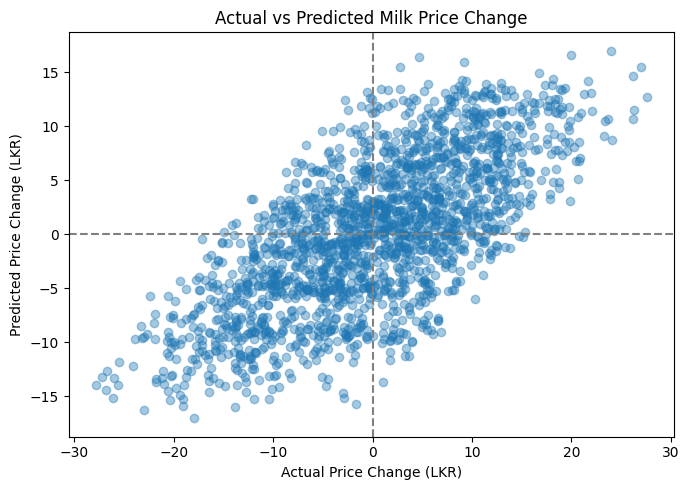

In [17]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Price Change (LKR)")
plt.ylabel("Predicted Price Change (LKR)")
plt.title("Actual vs Predicted Milk Price Change")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


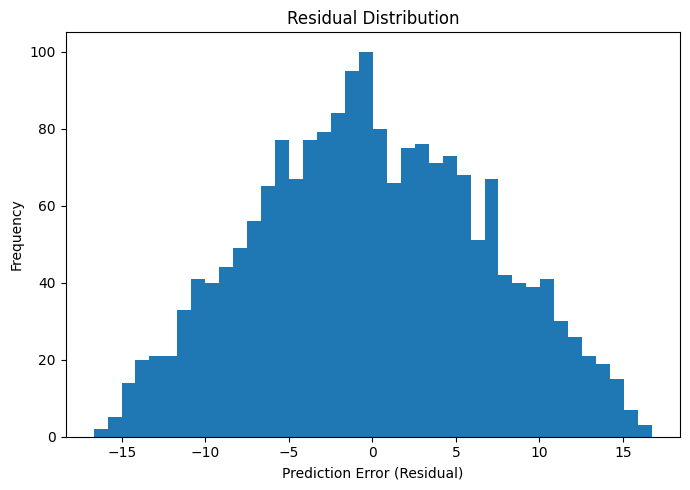

In [18]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40)
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()


In [19]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nKey Drivers of Milk Price Change:")
print(feature_importance)



Key Drivers of Milk Price Change:
                          Feature  Importance
0  Local_Milk_Price_LKR_per_Litre    0.860224
1             Monthly_Milk_Litres    0.038003
3                  SNF_Percentage    0.032482
2                  Fat_Percentage    0.028361
7                           Month    0.015100
6                 Lactation_Month    0.011922
5            Feed_Quality_Encoded    0.007523
4                   Disease_Stage    0.006383


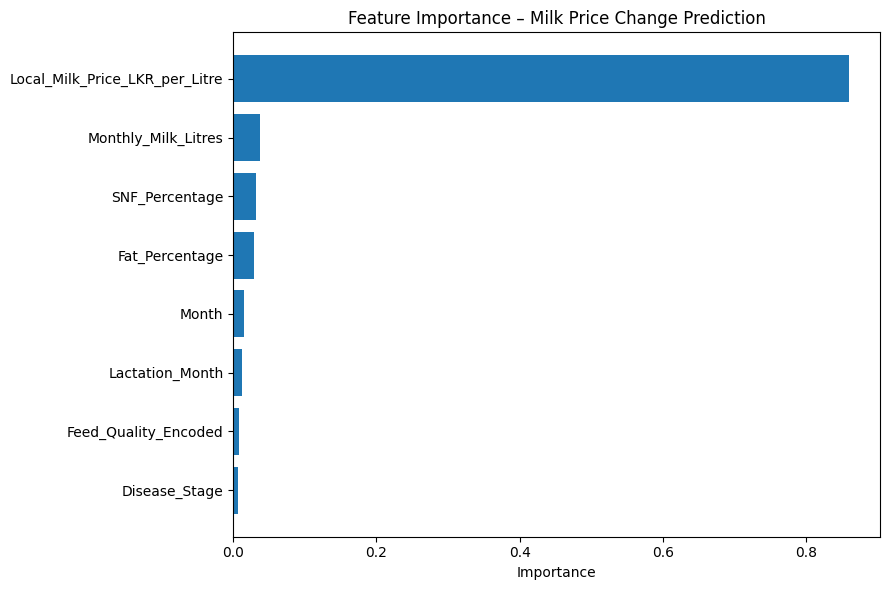

In [20]:
plt.figure(figsize=(9,6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importance – Milk Price Change Prediction")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [21]:
model_path = '/content/drive/MyDrive/cowproject2/predict_market/rf_milk_price_model.pkl'
joblib.dump(rf_model, model_path)

print(f"Model saved to: {model_path}")


Model saved to: /content/drive/MyDrive/cowproject2/predict_market/rf_milk_price_model.pkl


In [24]:
import joblib
import pandas as pd
import numpy as np

model_path = '/content/drive/MyDrive/cowproject2/predict_market/rf_milk_price_model.pkl'
model = joblib.load(model_path)

print("Model loaded successfully")


Model loaded successfully


In [25]:
input_data = {
    'Local_Milk_Price_LKR_per_Litre': 160,   # current price
    'Monthly_Milk_Litres': 320,              # expected production
    'Fat_Percentage': 4.2,
    'SNF_Percentage': 8.8,
    'Disease_Stage': 1,                      # 0–3
    'Feed_Quality_Encoded': 2,               # Low=1, Medium=2, High=3
    'Lactation_Month': 4,
    'Month': 7                               # July
}


In [26]:
X_input = pd.DataFrame([input_data])


In [27]:
predicted_price_change = model.predict(X_input)[0]

print(f"Predicted Price Change: {predicted_price_change:.2f} LKR/Litre")


Predicted Price Change: 15.15 LKR/Litre


In [28]:
current_price = input_data['Local_Milk_Price_LKR_per_Litre']
next_month_price = current_price + predicted_price_change

print(f"Predicted Next Month Milk Price: {next_month_price:.2f} LKR/Litre")


Predicted Next Month Milk Price: 175.15 LKR/Litre


In [30]:
expected_milk = input_data['Monthly_Milk_Litres']

next_month_income = expected_milk * next_month_price

print(f" Predicted Next Month Income: {next_month_income:.2f} LKR")


 Predicted Next Month Income: 56048.23 LKR
